# Implementacion de MobileNetV2+SSD<br>
Esta es una implementación de la arquitectura MobileNetv2 + SSD para una tarea relativamente más simple de determinar cuadros delimitadores para imágenes MNIST incrustadas en un cuadro. Cada cuadro contiene solo un dígito (28x28 MNIST incrustado en un cuadro de 224x224) sin aumento de datos.

En la implementación anterior, los datos reales del terreno contenían información sobre un solo cuadro delimitador, lo que significaba solo una predicción por imagen (referencia https://colab.research.google.com/github/rs9899/mySSDimplementation/blob/master/MobileNetSSD_v2.

cambié las salidas a una predicción para cada cuadro predeterminado (como debería ser, por lo que entendí del documento SSD)

Los comentarios mencionados a lo largo del código mencionan lo que debe cambiar si se modifican las entradas o salidas del modelo.

In [ ]:
import os
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
import numpy.matlib
from PIL import Image
from keras import backend as K
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import bottleneck

Defino Bottleneck Residual layer para MobileNet<br>
Usando los mismos parámetros que se mencionan en el documento

In [ ]:
class Bottleneck(keras.Model):
  def __init__(
      self,
      expansion,
      stride,
      block_id,
      filters,
      alpha=1,
      ):
    super(Bottleneck,self).__init__(name = "Bottleneck_" + block_id)
    self.stride = stride
    self.expansion = expansion
    self.alpha = alpha
    self.output_channels = self.alpha * filters
    self.out = None # there was some problem with the eager execution

    prefix =  'Bottleneck_{}_'.format(block_id)
    self.prefix = prefix
    # expansion
    self.expand_BN = layers.BatchNormalization(name = prefix + 'expand_BN')
    self.expand_ReLU = layers.ReLU(max_value=6, name = prefix + 'expand_ReLU')

    #conv
    self.Conv = layers.DepthwiseConv2D(
        kernel_size = 3,
        padding='same',
        strides = self.stride,
        use_bias = False,
        name = prefix + 'conv')
    self.Conv_BN = layers.BatchNormalization(name = prefix + 'conv_BN')
    self.Conv_ReLU = layers.ReLU(max_value=6, name = prefix + 'conv_ReLU')

    #project
    self.project = layers.Conv2D(
        filters = self.output_channels,
        kernel_size = 1,
        use_bias = False,
        name = 'contract')
    self.project_BN = layers.BatchNormalization(name = prefix + 'contract_BN')

    # dimensions need to be the same for residual connection
    self.residual = layers.Add(name=prefix + 'residual')
  
  def build(self, input_shape):
    self.d = input_shape[-1]
    
    self.expand = layers.Conv2D(
        filters = self.expansion*self.d,
        kernel_size = 1,
        use_bias = False,
        name = self.prefix+'expand')

      
  def call(self, inputs):

    x = self.expand(inputs)
    x = self.expand_BN(x)
    x = self.expand_ReLU(x)
    self.out = x
    
    x = self.Conv(x)
    x = self.Conv_BN(x)
    x = self.Conv_ReLU(x)

    x = self.project(x)
    x = self.project_BN(x)

    if self.output_channels == self.d and self.stride == 1:
      x = self.residual([inputs,x])

    return x

  def model(self):
      x = keras.Input(shape=(28,28,3))
      return keras.Model(inputs=[x], outputs=self.call(x))

Defino MobileNetv2<br>

Los mismos componentes que se mencionan en el documento (las dimensiones de la imagen de entrada son un poco diferentes)


In [ ]:
#using the architecture mentioned in the paper
class MobileNetv2(keras.Model):
  def __init__(self, k = 11):
    super(MobileNetv2,self).__init__()
    self.conv_inp = layers.Conv2D(
        filters = 32,
        kernel_size = 3,
        strides = (2,2),
        padding='valid',
        use_bias = False,
        name = 'conv'
    )
    self.k = k    

    self.pad = layers.ZeroPadding2D(padding=2,name='pad')
    self.BN = layers.BatchNormalization(name='BN')
    self.ReLU = layers.ReLU(max_value = 6, name = 'ReLU')
    
    self.B1_1 = Bottleneck(expansion = 1, filters = 16, stride = 1, block_id = 'B1_1')

    self.B2_1 = Bottleneck(expansion = 6, filters = 24, stride = 2, block_id = 'B2_1')
    self.B2_2 = Bottleneck(expansion = 6, filters = 24, stride = 1, block_id = 'B2_2')

    self.B3_1 = Bottleneck(expansion = 6, filters = 32, stride = 2, block_id = 'B3_1')
    self.B3_2 = Bottleneck(expansion = 6, filters = 32, stride = 1, block_id = 'B3_2')
    self.B3_3 = Bottleneck(expansion = 6, filters = 32, stride = 1, block_id = 'B3_3')

    self.B4_1 = Bottleneck(expansion = 6, filters = 64, stride = 2, block_id = 'B4_1')
    self.B4_2 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_2')
    self.B4_3 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_3')
    self.B4_4 = Bottleneck(expansion = 6, filters = 64, stride = 1, block_id = 'B4_4')

    self.B5_1 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_1')
    self.B5_2 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_2')
    self.B5_3 = Bottleneck(expansion = 6, filters = 96, stride = 1, block_id = 'B5_3')

    self.B6_1 = Bottleneck(expansion = 6, filters = 160, stride = 2, block_id = 'B6_1')
    self.B6_2 = Bottleneck(expansion = 6, filters = 160, stride = 1, block_id = 'B6_2')
    self.B6_3 = Bottleneck(expansion = 6, filters = 160, stride = 1, block_id = 'B6_3')

    self.B7_1 = Bottleneck(expansion = 6, filters = 320, stride = 1, block_id = 'B7_1')

    self.conv_out = layers.Conv2D(
        filters = 1280,
        kernel_size = 1,
        strides = (1,1),
        use_bias = False,
        name = 'conv_out'
    )
    self.avgpool = layers.AveragePooling2D(
        pool_size = (7,7),
        name='avg_pool'
        )
    
    self.conv_seg = layers.Conv2D(
        filters = self.k,
        kernel_size = 1,
        strides = (1,1),
        use_bias = False,
        name = 'conv_seg'
    )

  def call(self, inputs):
    x = self.conv_inp(inputs)
    x = self.BN(x)
    x = self.ReLU(x)

    x = self.B1_1(x)
    x = self.B2_1(x)
    x = self.B2_2(x)

    x = self.B3_1(x)
    x = self.B3_2(x)
    x = self.B3_3(x)
    
    x = self.B4_1(x)
    x = self.B4_2(x)
    x = self.B4_3(x)
    x = self.B4_4(x)
    
    x = self.B5_1(x)
    x = self.B5_2(x)
    x = self.B5_3(x)
    
    x = self.B6_1(x)
    x = self.B6_2(x)
    x = self.B6_3(x)
    
    x = self.B7_1(x)

    x = self.conv_out(x)
    x = self.avgpool(x)
    c4 = self.conv_seg(x)

    return c4

  def model(self):
      x = keras.Input(shape=(224,224,3))

      return keras.Model(inputs=x, outputs=self.call(x))

In [ ]:
MobileNetv2().model().summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv (Conv2D)               (None, 111, 111, 32)      864       
                                                                 
 BN (BatchNormalization)     (None, 111, 111, 32)      128       
                                                                 
 ReLU (ReLU)                 (None, 111, 111, 32)      0         
                                                                 
 Bottleneck_B1_1 (Bottleneck  (None, 111, 111, 16)     2144      
 )                                                               
                                                                 
 Bottleneck_B2_1 (Bottleneck  (None, 56, 56, 24)       5568      
 )                                                         

Definiendo SSD<br>

El número predeterminado de cuadros por capa y la resolución de cada capa es diferente, ya que estamos trabajando con datos MNIST y tamaños de imagen de 224x224.
Para cambiar el número de cuadros por capa y los anchos de capa, se deben tener en cuenta algunas restricciones que se mencionan en las secciones posteriores.

In [ ]:
class SSD(keras.Model):
  def __init__(self, numBoxes=[4,6,6,6,4,4], layerWidth=[28,14,7,4,2,1], k = 10+1+4):
    super(SSD,self).__init__()
    self.classes = k
    self.featureMaps = 6
    self.MobileNet = MobileNetv2(k=k)
    self.numBoxes = numBoxes
    self.layerWidth = layerWidth
    self.features = [None for _ in range(self.featureMaps)]
    self.classifiers = [None for _ in range(self.featureMaps)]
    
    self.conv1_1 = layers.Conv2D(256,1,name='SSD_conv_1_1')
    self.conv1_2 = layers.Conv2D(512,3,strides=(2,2),padding='same',name='SSD_conv_1_2')

    self.conv2_1 = layers.Conv2D(128,1,name='SSD_conv_2_1')
    self.conv2_2 = layers.Conv2D(256,3,strides=(2,2),padding='same',name='SSD_conv_2_2')
    
    self.conv3_1 = layers.Conv2D(128,1,name='SSD_conv_3_1')
    self.conv3_2 = layers.Conv2D(256,3,strides=(1,1),name='SSD_conv_3_2')
    
    self.conv4_1 = layers.Conv2D(128,1,name='SSD_conv_4_1')
    self.conv4_2 = layers.Conv2D(256,2,strides=(1,1),name='SSD_conv_4_2') # cambió el tamaño del kernel a 2 ya que la salida de la capa anterior tiene un ancho de 3

    self.conv = []
    self.reshape = []
    for i in range(self.featureMaps):
      self.conv.append(layers.Conv2D(self.numBoxes[i]*self.classes,3,padding='same',name='Classification_'+str(i)))
      self.reshape.append(layers.Reshape((self.layerWidth[i]* self.layerWidth[i] * self.numBoxes[i],self.classes),name='Reshape_classification_'+str(i)))

  def build(self, input_shape):
    self.MobileNet.build(input_shape)
  
  def call(self,inputs):
    x = inputs
    x = self.MobileNet(x)

    # obtener las imágenes convolucionadas a diferentes resoluciones
    self.features[0] = self.MobileNet.get_layer('Bottleneck_B4_1').out
    self.features[1] = self.MobileNet.get_layer('Bottleneck_B5_3').out
    self.features[2] = self.conv1_2(self.conv1_1(self.features[1]))
    self.features[3] = self.conv2_2(self.conv2_1(self.features[2]))
    self.features[4] = self.conv3_2(self.conv3_1(self.features[3]))
    self.features[5] = self.conv4_2(self.conv4_1(self.features[4]))

    for i in range(self.featureMaps):
    # para cada mapa de características, cree predicciones de acuerdo con la cantidad de cuadros para esa capa y la cantidad de canales de salida
      x = self.conv[i](self.features[i])
      x = self.reshape[i](x)
      self.classifiers[i] = x
    
    # Concatenar todos los classifiers
    x = layers.concatenate(self.classifiers, axis = -2, name='concatenate')
    return x


  def model(self):
      x = keras.Input(shape=(224,224,3))

      return keras.Model(inputs=x, outputs=self.call(x))

In [ ]:
NUM_CLASSES = 10
# Las primeras 2 dimensiones deben ser iguales al ancho de la salida del cuello de botella expandir ReLU en (4,1) y (5,3) respectivamente.
# Las dimensiones posteriores a la segunda están determinadas por las circunvoluciones escritas dentro del SSD (conv1_2, conv2_2, conv3_3, conv4_2)
layerWidths = [28,14,7,4,2,1]
numBoxes = [3,3,3,3,3,3]
assert len(numBoxes) == len(layerWidths) # numBoxes for each layer and each layer has a specific width
outputChannels = NUM_CLASSES + 1 + 4 # 10 classes + background + cx,cy,h,w
assert outputChannels - NUM_CLASSES == 5

In [ ]:
model = SSD(numBoxes=numBoxes, layerWidth=layerWidths, k = outputChannels)

Creando cajas (boxes) y IoU

In [ ]:
# Aquí he usado escalas personalizadas y relaciones de aspecto menos variables, ya que el conjunto de datos ya es uniforme
# IMPORTANTE: antes de cambiar las escalas y relaciones de aspecto, lea el comentario a continuación

# número de escalas es igual al número de resoluciones diferentes, es decir, número de anchos de capa
# para una resolución dada, tenemos diferentes relaciones de aspecto
# num(scales) = num(layerWidth) = num(numBoxes) and num(asp_ratios) = numBoxes[i]
MinScale = .1 # Min and Max scale given as percentage
MaxScale = 1.5
scales = [ MinScale + x/len(layerWidths) * (MaxScale-MinScale) for x in range(len(layerWidths)) ]
scales = scales[::-1] # invirtiendo el orden porque los anchos de capa van de mayor a menor (de menor a mayor resolución)

asp = [0.5,1.0,1.5]
asp1 = [x**0.5 for x in asp]
asp2 = [1/x for x in asp1]

In [ ]:
IMG_SIZE = 224

In [ ]:
# debe ser igual a la primera dimensión en la capa de salida del modelo SSD
BOXES = sum([a*a*b for a,b in zip(layerWidths,numBoxes)])
centres = np.zeros((BOXES,2))
hw = np.zeros((BOXES,2))
boxes = np.zeros((BOXES,4))
print(BOXES)

3150


In [ ]:
# calcular los centros de box centers predeterminados y height, width
idx = 0

for gridSize, numBox, scale in zip(layerWidths,numBoxes,scales):
  step_size = IMG_SIZE*1.0/gridSize
  for i in range(gridSize):
    for j in range(gridSize):
      pos = idx + (i*gridSize+j) * numBox
      # el centro es el mismo para todas las relaciones de aspecto(=numBox)
      centres[ pos : pos + numBox , :] = i*step_size + step_size/2, j*step_size + step_size/2
      # la altura y el ancho varían según la escala y la relación de aspecto
      # zip asepct ratios y luego escalarlas por el factor de escala
      hw[ pos : pos + numBox , :] = np.multiply(gridSize*scale, np.squeeze(np.dstack([asp1,asp2]),axis=0))[:numBox,:]

  idx += gridSize*gridSize*numBox 

In [ ]:
# (x,y) co-ordinates of top left and bottom right
# This actually is not used anywhere. centres[] and hw[] are a good enough substitute
boxes[:,0] = centres[:,0] - hw[:,0]/2
boxes[:,1] = centres[:,1] - hw[:,1]/2
boxes[:,2] = centres[:,0] + hw[:,0]/2
boxes[:,3] = centres[:,1] + hw[:,1]/2

In [ ]:
# calculate IoU for a set of search boxes and default boxes
def IoU(box1, box2):
  box1 = box1.astype(np.float64)
  box2 = box2.astype(np.float64)
  # find the left and right co-ordinates of the edges. Min should be less than Max for non zero overlap
  xmin = np.maximum(box1[:,0],box2[:,0])
  xmax = np.minimum(box1[:,2],box2[:,2])
  ymin = np.maximum(box1[:,1],box2[:,1])
  ymax = np.minimum(box1[:,3],box2[:,3])

  intersection = np.abs(np.maximum(xmax-xmin,0) * np.maximum(ymax-ymin,0))
  boxArea1 = np.abs((box1[:,2] - box1[:,0]) * (box1[:,3] - box1[:,1]))
  boxArea2 = np.abs((box2[:,2] - box2[:,0]) * (box2[:,3] - box2[:,1]))
  unionArea = boxArea1 + boxArea2 - intersection
  assert (unionArea > 0).all()
  iou = intersection / unionArea

  return iou

In [ ]:
# give the index of the box correpsonding to the IoUs > threshold (=0.5) 
def bestIoU(searchBox):
  return np.argwhere(IoU(numpy.matlib.repmat(searchBox,BOXES,1), boxes) > 0.5)

Loading Data

In [ ]:
TRAINSIZE = 600
TESTSIZE = 100

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:TRAINSIZE , : , :]
y_train = y_train[:TRAINSIZE]
x_test = x_test[:TESTSIZE , : , :]
y_test = y_test[:TESTSIZE]

In [ ]:
# take mnist x and y pairs and convert to input, output pairs for the MobileNetv2+SSD model
def convert(x,y):
  MNIST_SIZE = x.shape[-1]
  # create a 2D array of top left corners for the mnist image to be placed
  corner = np.random.randint(IMG_SIZE - MNIST_SIZE, size=(x.shape[0],2))

  # create a blank canvas for the input with the required dimension
  input = np.zeros((x.shape[0], IMG_SIZE, IMG_SIZE, 3))

  # replacing a part by RGB version of MNIST
  for i in range(x.shape[0]):
    lx = int(corner[i,0])
    ly = int(corner[i,1])
    input[i,lx:lx + MNIST_SIZE, ly:ly+MNIST_SIZE,:] = np.repeat(np.expand_dims(np.array(x[i,:,:]),axis=-1),3,axis=-1)

  # for each default box, there are 5 values: class number and delta cx,cy,h,w
  output = np.zeros((y.shape[0],BOXES,1+4))
  output[:,:,0] = NUM_CLASSES # defaulting class labels for all boxes to background initially
  for i in range(x.shape[0]):
    bbox = np.zeros(4)
    bbox[:2] = corner[i]
    bbox[2:] = corner[i] + (MNIST_SIZE,MNIST_SIZE)
    # for all default boxes which have IoU > threshold, set the delta values and class number
    box_idx = bestIoU(bbox).astype(np.uint16)
    output[i,box_idx,0] = y[i]
    output[i,box_idx,1] = (bbox[0] + bbox[2])/2.0 - centres[box_idx,0]
    output[i,box_idx,2] = (bbox[1] + bbox[3])/2.0 - centres[box_idx,1]
    output[i,box_idx,3] = MNIST_SIZE - hw[box_idx,0]
    output[i,box_idx,4] = MNIST_SIZE - hw[box_idx,1]

  return input, output


In [ ]:
test_x, test_y = convert(x_test,y_test)
train_x, train_y = convert(x_train,y_train)

Number of boxes with IoU > 0.5: 8
Green box: ground truth. Red box: default boxes with IoU > threshold


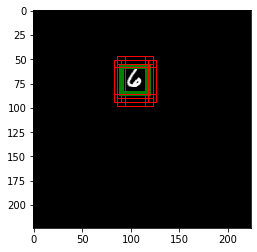

In [ ]:
# checking if the inputs prepared are correct or not
r = np.random.randint(0,train_x.shape[0])
img = train_x[r,:,:,:].copy()
img_y = train_y[r]

im = np.array(Image.fromarray(img.astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

# find all boxes where class label is not background
idx = np.argwhere(img_y[:,0] != NUM_CLASSES)[:,0]
print('Number of boxes with IoU > 0.5:',idx.shape[0])
print('Green box: ground truth. Red box: default boxes with IoU > threshold')

#calculating the ground truth bounding boxes
gt = np.zeros(4,dtype=np.uint16)
gt[:2] = (img_y[idx[0],1:3] + centres[idx[0],:2])
gt[2:] = (img_y[idx[0],3:] + hw[idx[0],:])

# for some reason, x and y are inverted
rect = patches.Rectangle((gt[1]-gt[3]/2,gt[0]-gt[2]/2),gt[3],gt[2],linewidth=5,edgecolor='g',facecolor='none')
ax.add_patch(rect)

# showing all the boxes with IoU > 0.5
for i in idx:
  rect = patches.Rectangle((centres[i][1]-hw[i,1]/2,centres[i][0]-hw[i,0]/2),hw[i,1],hw[i,0],linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

plt.show()

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))
print(train_dataset.element_spec)
print(test_dataset.element_spec)

(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(3150, 5), dtype=tf.float64, name=None))
(TensorSpec(shape=(224, 224, 3), dtype=tf.float64, name=None), TensorSpec(shape=(3150, 5), dtype=tf.float64, name=None))


In [ ]:
BATCH_SIZE = 10
SHUFFLE_BUFFER_SIZE = 60

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE,drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE,drop_remainder=True)

LOSS FUNCTION<br>
Hard negative mining hasn't been done here<br>
La idea inicial era asignar pesos a las clases de fondo, pero hay algún problema en ese enfoque

In [ ]:
# la etiqueta no se requiere aquí en la implementación estándar
# calculando the smooth L1 loss
def smoothL1(x,y,label):
  diff = K.abs(x-y) #* K.switch(label == 10, label*1.0/BOXES, label)
  result = K.switch(diff < 1, 0.5 * diff**2, diff - 0.5)
  return K.mean(result)

In [ ]:
def confidenceLoss(y,label):
  unweighted_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(label, y)
  # class_weights = tf.constant([[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0/BOXES]]*BOXES])
  # weights = tf.reduce_sum(class_weights * y, axis = -1)
  # weighted_loss = unweighted_loss * weights
  return K.mean(unweighted_loss)

In [ ]:
def Loss(gt,y):
  # shape of y is n * BOXES * output_channels
  # shape of gt is n * BOXES * 5 
  loss = 0
  # localisation loss
  loss += smoothL1(y[:,:,-4:],gt[:,:,-4:],gt[:,:,0:1])
  # confidence loss
  loss += confidenceLoss(y[:,:,:-4],tf.cast(gt[:,:,0],tf.int32))
  return loss

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),loss=Loss, metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data = test_dataset)

Epoch 1/100
60/60 [==============================] - 13s 96ms/step - loss: 0.3620 - accuracy: 8.3016e-04 - val_loss: 0.2103 - val_accuracy: 0.0000e+00
Epoch 2/100
60/60 [==============================] - 5s 82ms/step - loss: 0.0907 - accuracy: 3.4815e-04 - val_loss: 0.0507 - val_accuracy: 0.0000e+00
Epoch 3/100
60/60 [==============================] - 5s 80ms/step - loss: 0.0635 - accuracy: 2.0423e-04 - val_loss: 0.0597 - val_accuracy: 0.0000e+00
Epoch 4/100
60/60 [==============================] - 5s 82ms/step - loss: 0.0558 - accuracy: 2.7725e-04 - val_loss: 0.0781 - val_accuracy: 0.0000e+00
Epoch 5/100
60/60 [==============================] - 5s 82ms/step - loss: 0.0456 - accuracy: 1.3545e-04 - val_loss: 0.0354 - val_accuracy: 0.0000e+00
Epoch 6/100
60/60 [==============================] - 5s 81ms/step - loss: 0.0350 - accuracy: 1.2857e-04 - val_loss: 0.0265 - val_accuracy: 6.3492e-06
Epoch 7/100
60/60 [==============================] - 5s 82ms/step - loss: 0.0356 - accuracy: 1.0159

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


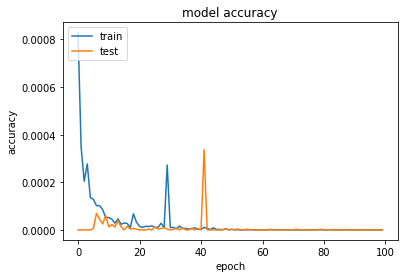

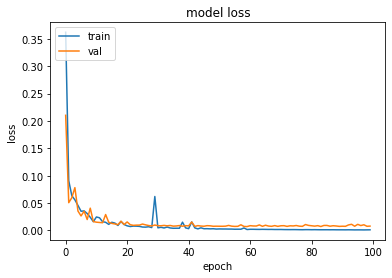

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_x,test_y)

4/4 [==============================] - 1s 34ms/step - loss: 0.0079 - accuracy: 0.0000e+00


[0.007887649349868298, 0.0]

INFERENCE

In [ ]:
# model.save("model_mbnv2.h5")
from google.colab import drive
drive.mount('/content/drive')

model.save_weights("/content/drive/MyDrive/Master/Asignaturas/4 - Aprendizaje Profundo AP/mbnv2/model_mbnv2_weights.h5") # serialize weights to HDF5
    
# tf.saved_model.save(model, "model_mbnv2.h5")
# model.save('model_mbnv2',save_format='tf')
# model.save_weights("weights_model_mbnv2.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Sección nueva

In [ ]:
# model = load_model("model_mbnv2.h5")  
# model.load_weights("weights_model_mbnv2.h5")
# model.summary()
model.load_weights('/content/drive/MyDrive/Master/Asignaturas/4 - Aprendizaje Profundo AP/mbnv2/model_mbnv2_weights.h5')

In [ ]:
# create some sample data
X, Y = convert(x_test, y_test)

In [ ]:
# obtener predicción para una muestra
y_pred = model.predict(X)
y_pred.shape

(100, 3150, 15)

In [ ]:
OBJperCLASS = 10 # obtener los 10 mejores resultados para cada clase
# obtener los puntajes de confianza (con valores de clase) y delta para las cajas. Para cada clase, se utilizan los 10 valores principales
def infer(Y):
  # las clases son en realidad el índice en los cuadros predeterminados
  classes = np.zeros((OBJperCLASS,outputChannels-4),dtype=np.uint16)
  conf = np.zeros((OBJperCLASS,outputChannels-4))
  delta = np.zeros((OBJperCLASS,outputChannels-4,4))
  class_predictions = softmax(Y[:,:outputChannels-4],axis=1)
  for i in range(outputChannels-4):
    classes[:,i] = bottleneck.argpartition(class_predictions[:,i],BOXES-1-10,axis=-1)[-OBJperCLASS:]
    conf[:,i] = class_predictions[classes[:,i],i]
    delta[:,i] = Y[classes[:,i],outputChannels-4:]
  return conf,classes, delta

# generar cuadros delimitadores a partir de las salidas inferidas
def Bbox(confidence,box_idx,delta):
  #delta contiene delta(cx,cy,h,w)
  bbox_centre = np.zeros((OBJperCLASS,outputChannels-4,2))
  bbox_hw = np.zeros((OBJperCLASS,outputChannels-4,2))
  for i in range(OBJperCLASS):
    bbox_centre[i,:,0] = centres[box_idx[i]][:,0]+delta[i,:,0]
    bbox_centre[i,:,1] = centres[box_idx[i]][:,1]+delta[i,:,1]
    bbox_hw[i,:,0] = hw[box_idx[i]][:,0] + delta[i,:,2]
    bbox_hw[i,:,1] = hw[box_idx[i]][:,1]+delta[i,:,3]
  return bbox_centre,bbox_hw

1: Confidence-4.823760718863923e-06		Centre-[ 43.99149526 124.00630489] Height,Width-[25.08742309 50.14149439]
1: Confidence-0.006267999764531851		Centre-[ 66.84070015 131.74984047] Height,Width-[28.17098793 27.96914591]
1: Confidence-0.1453598141670227		Centre-[ 64.73491192 132.39694643] Height,Width-[29.5209088  29.53773495]
1: Confidence-0.30047962069511414		Centre-[ 66.58109128 131.33177233] Height,Width-[28.07906884 28.17808615]
1: Confidence-7.904074300313368e-05		Centre-[ 67.18375844 125.88069284] Height,Width-[33.48129114 33.48535797]
1: Confidence-0.3060176372528076		Centre-[ 66.37387252 131.07256013] Height,Width-[28.08422917 28.07446181]
1: Confidence-0.09855780750513077		Centre-[ 66.72302401 131.44829214] Height,Width-[28.46598622 28.47977969]
1: Confidence-0.05936429277062416		Centre-[ 66.50412977 131.26611429] Height,Width-[28.78635773 27.99102886]
1: Confidence-0.6705504655838013		Centre-[ 66.51125646 131.16567039] Height,Width-[28.20178383 27.50552451]
1: Confidence-0.0

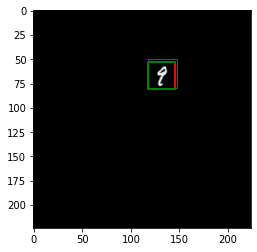

In [ ]:
r = np.random.randint(TESTSIZE)

# Las 10 mejores predicciones para cada clase
confidence, box_idx, delta = infer(y_pred[r])
bbox_centre,bbox_hw = Bbox(confidence, box_idx, delta)

im = np.array(Image.fromarray(X[r].astype(np.uint8)))
fig,ax = plt.subplots(1)
ax.imshow(im)

for i in range(outputChannels-4):
  # saltando fondo
  if i == NUM_CLASSES:
    continue
  color = 'r'
  # si se menciona una clase en la deteccion de verdad, colorea los cuadros de verde
  if i in Y[r,:,0]:
    color = 'g'
    print(i)
  
  # omitir todas las clases que tienen valores de confianza bajos
  if (confidence[:,i] > 0.5).any() or i in Y[r,:,0]:
    for k in range(OBJperCLASS):
      print("{}: Confidence-{}\t\tCentre-{} Height,Width-{}".format(i,confidence[k,i],bbox_centre[k,i],bbox_hw[k,i]))
      
      # dibuja un cuadro delimitador solo si las puntuaciones de confianza son altas
      if confidence[k,i] < 0.5:
        continue
      x = bbox_centre[k,i,0] - bbox_hw[k,i,0]/2
      y = bbox_centre[k,i,1] - bbox_hw[k,i,1]/2
      rect = patches.Rectangle((y,x),bbox_hw[k,i,1],bbox_hw[k,i,0],linewidth=1,edgecolor=color,facecolor='none')
      ax.add_patch(rect)

plt.show()